In [1]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)
    
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
from smt.surrogate_models import (
    KRG,
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
from smt.problems import WingWeight
from smt.sampling_methods import LHS
from sklearn.metrics import mean_squared_error
from smt.explainability_tools import ShapFeatureImportanceDisplay, ShapDisplay

import time
import numpy as np


# Creating the models

In [2]:
ndoe = 300 
fun = WingWeight()
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
X = sampling(ndoe)
y = fun(X)

n_train = int(0.8 * ndoe)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

## config
feature_names = [
    r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$', 
    r'$q$', r'$\lambda$', r'$t_{c}$', r'$N_{z}$', 
    r'$W_{dg}$', r'$W_{p}$',
]

# X_tr = pd.read_csv('../../X_tr_wing_weight.csv')
# X_te = pd.read_csv('../../X_te_wing_weight.csv')
# y_tr = pd.read_csv('../../y_tr_wing_weight.csv')
# y_te = pd.read_csv('../../y_te_wing_weight.csv')
# X_tr = np.array(X_tr)
# X_te = np.array(X_te)
# y_tr = np.array(y_tr)
# y_te = np.array(y_te)

In [3]:
%%time
kriging_model = KRG(
    theta0=[1e-2]*X_tr.shape[1],
    print_prediction = False
    )
kriging_model.set_training_values(
    X_tr, 
    y_tr
    )

kriging_model.train()
y_pred = kriging_model.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 240
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  5.4260809
RMSE: 0.1650
CPU times: user 30.7 s, sys: 8.36 s, total: 39 s
Wall time: 5.46 s


# Feature importance

Using `ShapFeatureImportanceDisplay.from_surrogate_model` method
- Required parameters:
    - model: surrogate model. 
    - X: input spaces as a reference to create the partial dependence plot. 

- Config parameters:
    - feature_names: name of the features for the axis. 
    - sort: if True, sort the features based on the feature importance. 

CPU times: user 50.3 s, sys: 39.9 s, total: 1min 30s
Wall time: 12.9 s


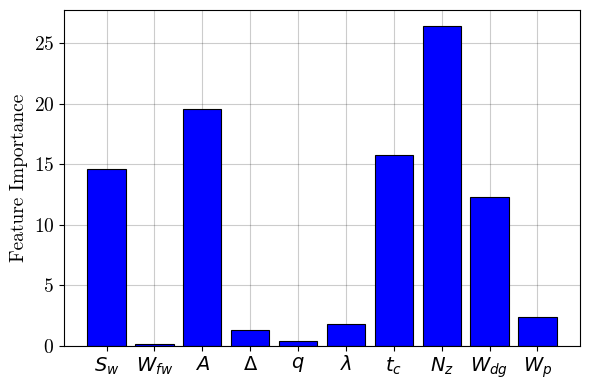

In [4]:
%%time
model = kriging_model
X = X_tr

feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    feature_names=feature_names,
)


# Shap Explainer

## Individual plot

CPU times: user 11.9 s, sys: 11.4 s, total: 23.4 s
Wall time: 3.33 s


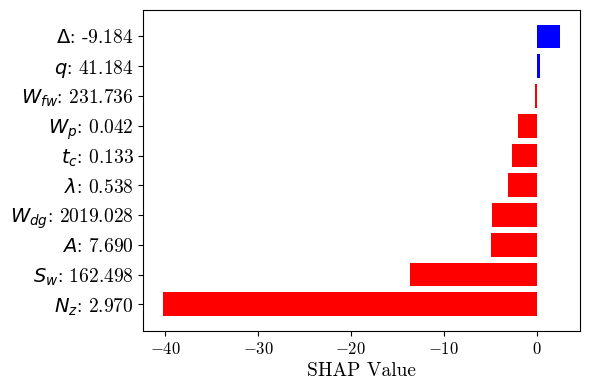

In [6]:
%%time
instances = X_te
model = kriging_model
# filename = "example_results/shap/blabla.png"

explainer_test = ShapDisplay.from_surrogate_model(
    instances, 
    model, 
    X_tr, 
    feature_names=feature_names,
)
# explainer_test.individual_plot(filename=filename)
explainer_test.individual_plot(index=0)

## Dependence plot

In [7]:
%%time
instances = X_tr
model = kriging_model
X = X_tr
explainer_train = ShapDisplay.from_surrogate_model(
    instances, 
    model, 
    X, 
    feature_names=feature_names,
)

CPU times: user 37.1 s, sys: 47.8 s, total: 1min 24s
Wall time: 12.1 s


CPU times: user 1.87 s, sys: 80.3 ms, total: 1.95 s
Wall time: 1.33 s


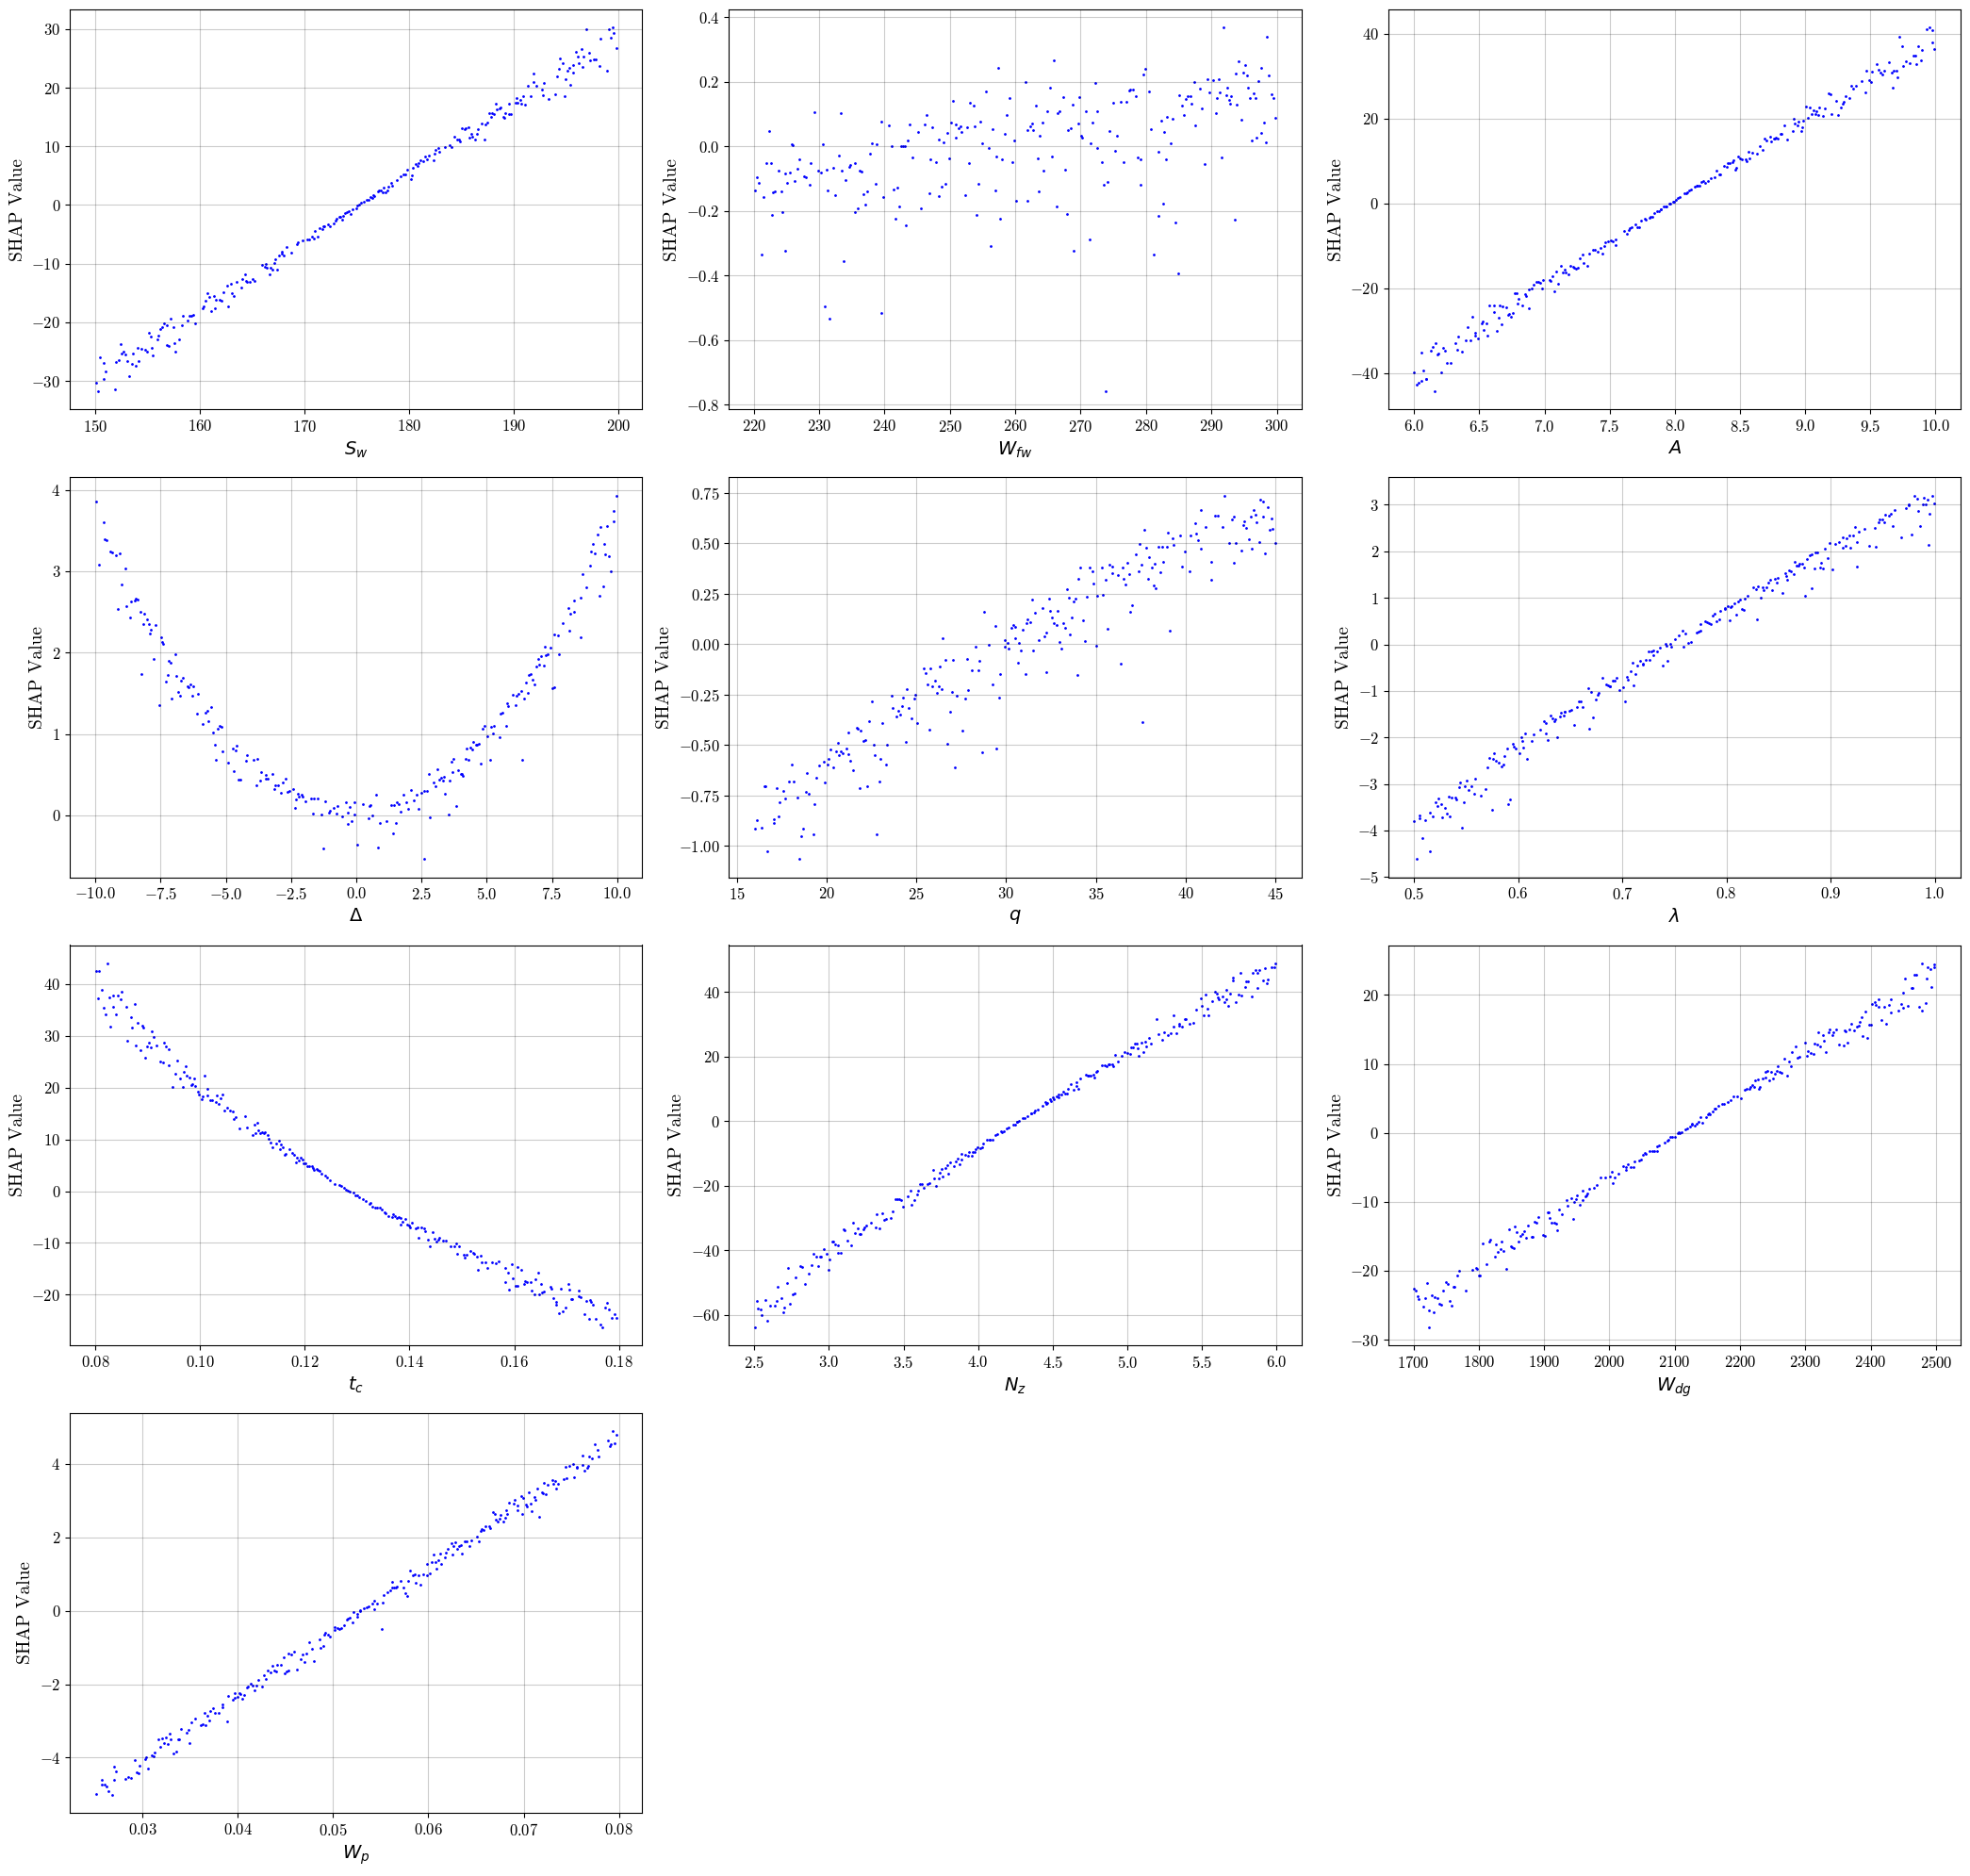

In [8]:
%%time
features = [i for i in range(X_tr.shape[1])]

explainer_train.dependence_plot(features)

## Interaction plot

CPU times: user 490 ms, sys: 26.4 ms, total: 516 ms
Wall time: 224 ms


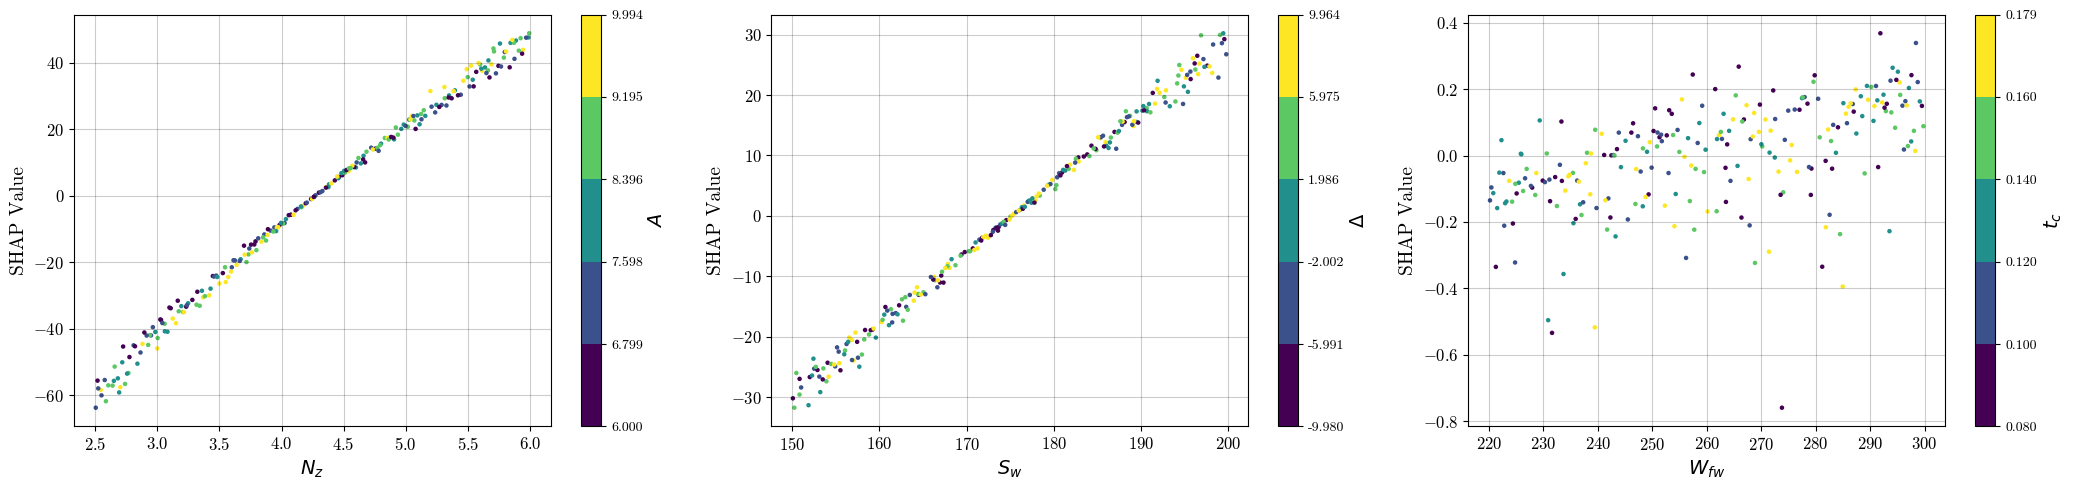

In [9]:
%%time
feature_pairs = [(7, 2), (0, 3), (1, 6)]
explainer_train.interaction_plot(
    feature_pairs, 
    n_color=5,
)

## Summary plot

CPU times: user 385 ms, sys: 11.8 ms, total: 397 ms
Wall time: 152 ms


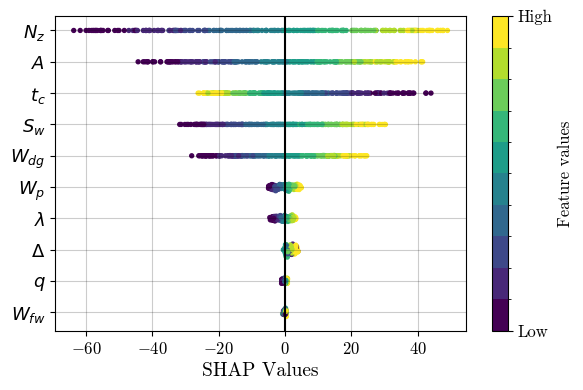

In [10]:
%%time
explainer_train.summary_plot()

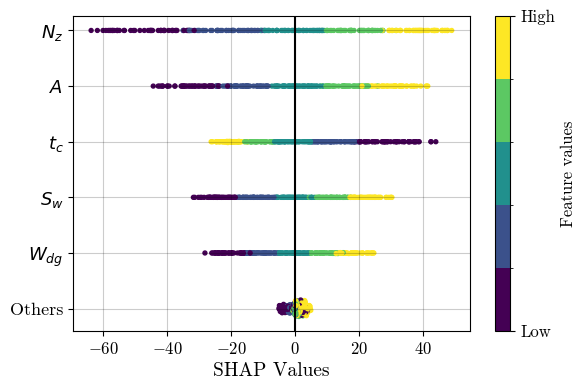

In [11]:
explainer_train.summary_plot(n_color=5, max_num_features=5)